In [3]:
import importlib
from sklearn.utils import gen_batches
import numpy as np
from numpy.linalg import norm
from Code.SGDPLS import SGDPLS
from Code.OLPLS import OLPLS
from Code.CIPLS import CIPLS
from Code.SIMPLS import SIMPLS
from Code.IPLS import IPLS
from Code.PLS1 import IPLS1
import h5py
# ----------
import seaborn as sns
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pytictoc import TicToc
tim=TicToc()

In [4]:
with np.load("./data/lfw.npz") as data:
    fea_train = data['fea_train']
    fea_test  = data['fea_test']
    X_train    = data['X_train']
    label_train    = data['y_train']
    X_test    = data['X_test']
    label_test    = data['y_test']
print(fea_train.shape)
print(fea_test.shape)
# print(X_train.shape)
# print(X_test.shape)
print(label_train.shape)
print(label_test.shape)


(2200, 512)
(1000, 512)
(2200,)
(1000,)


In [5]:
fea_train, label_train = shuffle(fea_train, label_train, random_state=42)

n_train = fea_train.shape[0]
batch_size = 100
batch_num = int(n_train/batch_size)
print(f"n_train: {n_train:d}; batch_num: {batch_num:d}, batch_size: {batch_size:d}")

# batches = gen_batches(n_train, batch_size)
train_ind = slice((None, n_train))
trainset = [ slice((i+1)*batch_size) for i in range(batch_num)]

samples = [(i+1)*batch_size for i in range(batch_num)]


n_train: 2200; batch_num: 22, batch_size: 100


In [28]:
def RunExp(method, PLS, is_inc, save):
    tim = TicToc()
    timlist=np.zeros((2, len(trainset)))
    timlist[0] = np.array(samples)
    X_score_train = np.zeros((fea_train.shape[0], 1))
    if (is_inc):
        for i,s in enumerate(gen_batches(n_train, batch_size)):
            tim.tic()
            PLS.fit(fea_train[s], label_train[s])
            timlist[1,i] = tim.tocvalue()
            X_score_train[s] = norm(PLS.transform(fea_train[s]), ord=1, axis=1, keepdims=True)
    else:
        for i,s in enumerate(trainset):
            tim.tic()
            PLS.fit(fea_train[s], label_train[s])
            timlist[1,i] = tim.tocvalue()
        X_score_train = norm(PLS.transform(fea_train), ord=1, axis=1, keepdims=True)

    X_score_test  = norm(PLS.transform(fea_test), ord=1, axis=1, keepdims=True)
    y_pred = LogisticRegression(penalty=None).fit(X_score_train, label_train) \
                                              .predict(X_score_test)
    acc = accuracy_score(label_test, y_pred)

    if (save==1):
        if (method == "CIPLS"):
            W = PLS.w_rotation
        elif (method == "NIPALS"):
            W = PLS.x_rotations_
        elif (method == "SIMPLS"):
            W = PLS.x_weights_
        elif ((method == "ISIMPLS") |
              (method == "PLS1") |
              (method == "IPLS1") |
              (method == "OLPLS")):
            W = PLS.W
        elif (method == "SGDPLS"):
            W = PLS.U
        elif (method == "IPLS"):
            W = PLS.x_rotations

        with h5py.File(f"./Results/PLS1_LFW_{method}.h5", "w") as f:
            f_W = f.create_dataset("weight", data=W, maxshape=W.shape)
            f_tim = f.create_dataset('timer', data=timlist, maxshape=timlist.shape)


In [31]:
def Read_Results(method):
    with h5py.File(f"./Results/PLS1_LFW_{method}.h5", "r") as f:
        dat={"timer": f["timer"][:],
             "weight":  f["weight"][:]}
    return dat

def timer_stats(method, timer):
    print(f"{method:s} timer\n"
      + f"  Ave: {np.mean(timer):.4f}\n"
      + f"  Std: {np.std(timer):.4f}")

In [15]:
from sklearn.cross_decomposition import PLSRegression

save=1
tim.tic()

RunExp('NIPALS', PLSRegression(n_components=31, scale=False),
       False, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 2.3315344117581844


In [16]:
save=1
tim.tic()

RunExp('SIMPLS', SIMPLS(n_components=34),
       False, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.4079465791583061


In [17]:
from Code.ISIMPLS import ISIMPLS
save=1
tim.tic()
RunExp('ISIMPLS', ISIMPLS(n_components=41),
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.30943077243864536


In [18]:
from Code.PLS1 import PLS1
save=1
tim.tic()
RunExp('PLS1', PLS1(n_components=69),
       False, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.5100859738886356


In [19]:
from Code.PLS1 import IPLS1
save=1
tim.tic()
RunExp('IPLS1', IPLS1(n_components=89),
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.5244078878313303


In [29]:
from Code.OLPLS import OLPLS
save=1
tim.tic()
RunExp('OLPLS', OLPLS(n_components=1, mu=6.6538e-9, amnesic=4.8396e-2),
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 1.0118544157594442


In [24]:
from Code.SGDPLS import SGDPLS
save=1
tim.tic()
RunExp('SGDPLS', SGDPLS(n_components=84, eta=4.4383e-5),
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 146.56261566840112


In [25]:
from Code.CIPLS import CIPLS
save=1
tim.tic()
RunExp('CIPLS', CIPLS(n_components=2), 
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 1.8740634433925152


In [32]:
from Code.IPLS import IPLS
save=1
tim.tic()
RunExp('IPLS', IPLS(n_components=8), 
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 3.709480045363307


In [34]:
NIPALS  = Read_Results("NIPALS")
OLPLS   = Read_Results("OLPLS")
SGDPLS   = Read_Results("SGDPLS")
PLS1    = Read_Results("PLS1")
IPLS1   = Read_Results("IPLS1")
SIMPLS  = Read_Results("SIMPLS")
ISIMPLS = Read_Results("ISIMPLS")
CIPLS   = Read_Results("CIPLS")
IPLS    = Read_Results("IPLS")

# print("NIPALS v.s. OLPLS")
# print("  RMSE of weight.:  {:15.7e}".format(RMSE(NIPALS['weight'], OLPLS['weight'])) )
# print("NIPALS v.s. SGDPLS")
# print("  RMSE of weight.:  {:15.7e}".format(RMSE(NIPALS['weight'], SGDPLS['weight'])) )
# print("NIPALS v.s. CIPLS")
# print("  RMSE of weight.:  {:15.7e}".format(RMSE(NIPALS['weight'], CIPLS['weight'])) )
# print("NIPALS v.s. IPLS")
# print("  RMSE of weight.:  {:15.7e}".format(RMSE(NIPALS['weight'], IPLS['weight'])) )

# print("SIMPLS v.s. ISIMPLS")
# print("  RMSE of weight.:  {:15.7e}".format(RMSE(SIMPLS['weight'], ISIMPLS['weight'])))
# print("PLS1 v.s. IPLS1")
# print("  RMSE of weight.:  {:15.7e}".format(RMSE(PLS1['weight'], IPLS1['weight'])))
# print("\n")

timer_stats("NIPALS", NIPALS['timer'][1])
timer_stats("SIMPLS", SIMPLS['timer'][1])
timer_stats("PLS1", PLS1['timer'][1])

timer_stats("OLPLS", OLPLS['timer'][1])
timer_stats("SGDPLS", SGDPLS['timer'][1])
timer_stats("ISIMPLS", ISIMPLS['timer'][1])
timer_stats("IPLS1", IPLS1['timer'][1])
timer_stats("CIPLS", CIPLS['timer'][1])
timer_stats("IPLS", IPLS['timer'][1])


NIPALS timer
  Ave: 0.1042
  Std: 0.0455
SIMPLS timer
  Ave: 0.0170
  Std: 0.0044
PLS1 timer
  Ave: 0.0216
  Std: 0.0060
OLPLS timer
  Ave: 0.0443
  Std: 0.0100
SGDPLS timer
  Ave: 6.6577
  Std: 0.1037
ISIMPLS timer
  Ave: 0.0122
  Std: 0.0032
IPLS1 timer
  Ave: 0.0212
  Std: 0.0058
CIPLS timer
  Ave: 0.0834
  Std: 0.0074
IPLS timer
  Ave: 0.1456
  Std: 0.0068


<Figure size 640x480 with 0 Axes>

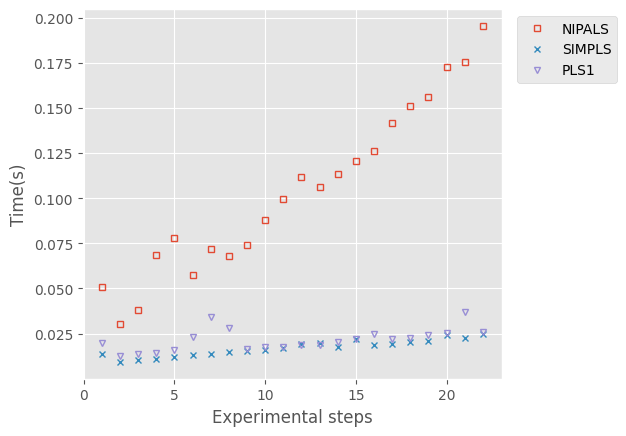

In [35]:
N_steps= len(ISIMPLS['timer'][0])
plt.subplots_adjust(right=.65)
fig, ax = plt.subplots()
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), NIPALS['timer'][1],
                label='NIPALS', ls='', marker='s', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), SIMPLS['timer'][1],
                label='SIMPLS', ls='', marker='x', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), PLS1['timer'][1],
                label='PLS1', ls='', marker='v', markersize=ms, fillstyle='none')


ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/LFW_full.pdf')
# plt.close()

<Figure size 640x480 with 0 Axes>

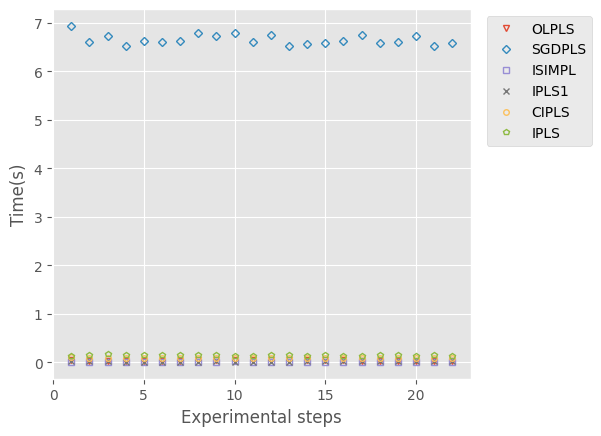

In [36]:
N_steps= len(ISIMPLS['timer'][0])
plt.subplots_adjust(right=.65)
fig, ax = plt.subplots()
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), OLPLS['timer'][1],
                label='OLPLS', ls='', marker='v', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), SGDPLS['timer'][1],
                label='SGDPLS', ls='', marker='D', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), ISIMPLS['timer'][1],
                label='ISIMPL', ls='', marker='s', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), IPLS1['timer'][1],
                label='IPLS1', ls='', marker='x', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), CIPLS['timer'][1],
                label='CIPLS', ls='', marker='o', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), IPLS['timer'][1],
                label='IPLS', ls='', marker='p', markersize=ms, fillstyle='none')



ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/LFW_inc.pdf')
# plt.close()